In [1]:
%cd ..

/users/fzanetta/pyprojects/bernstein-flow


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Float, Array
import matplotlib.pyplot as plt
from jax.scipy.stats import beta


from bernstein_flow.bijector_alt import BernsteinBijector

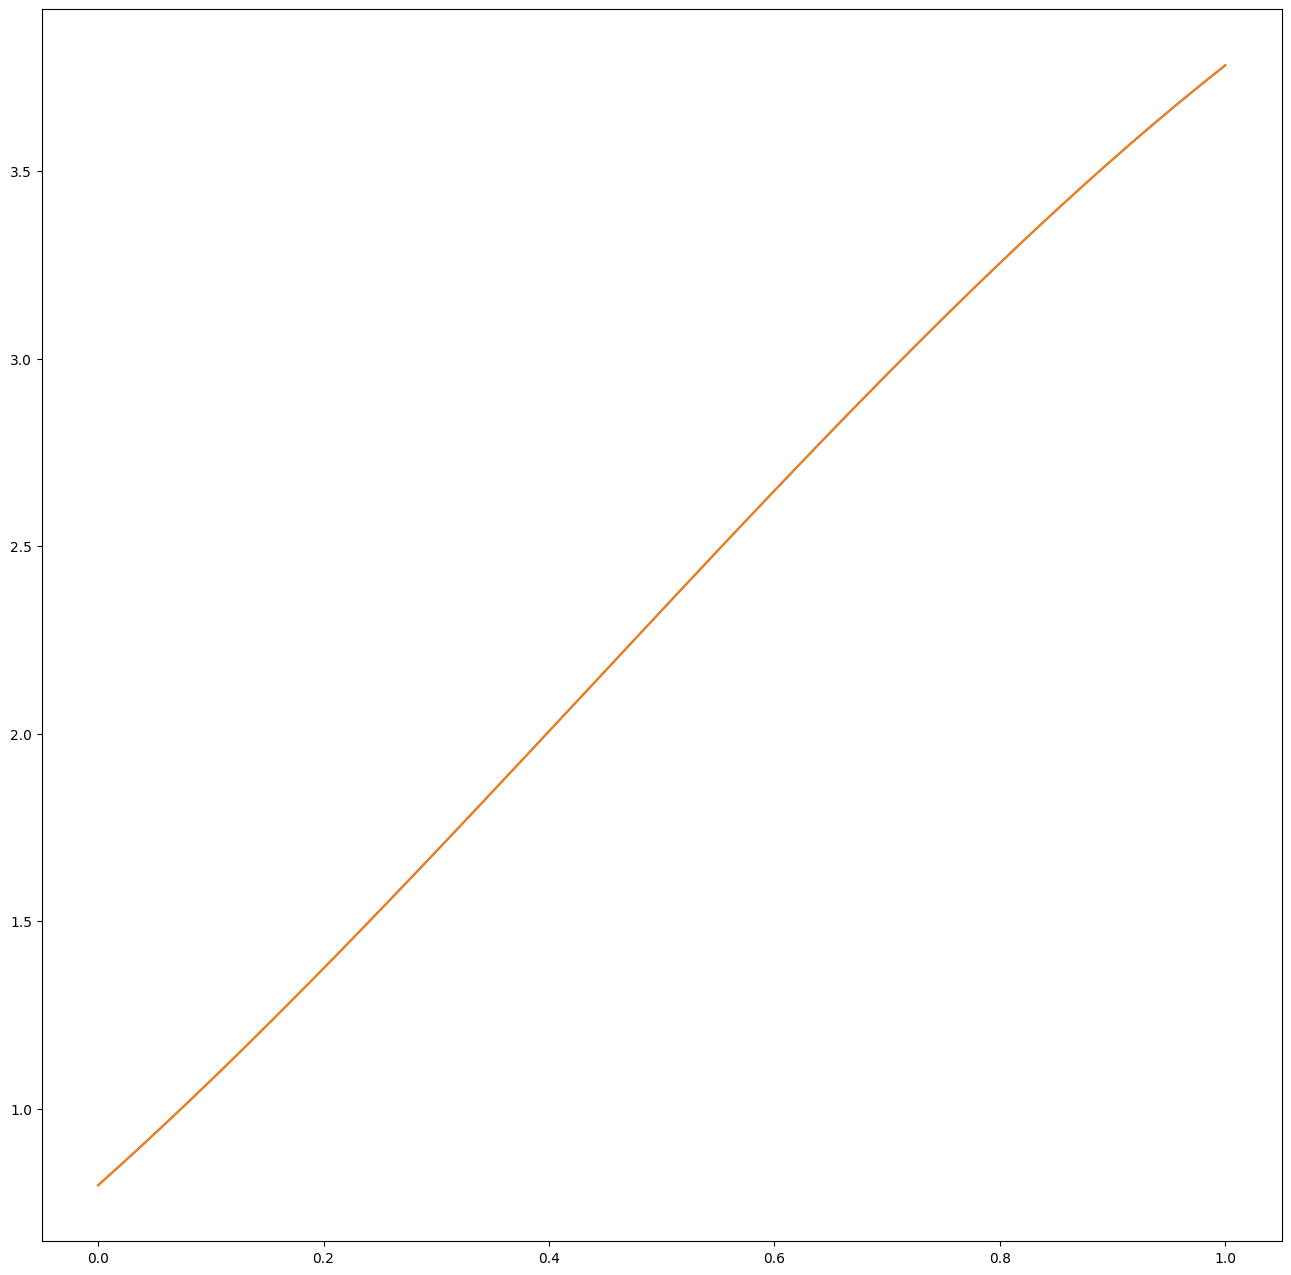

In [7]:
M = 4
# ensure monotonicity
bs = BernsteinBijector(np.random.normal(0, 1, (M,)))
yy = np.linspace(0, 1, 200, dtype=np.float32)
zz = bs.forward(yy)
# Prevent caching -> use spline interpolation
zi = zz + 1e-15 * np.random.random(zz.shape)
yyy = bs.inverse(zi)

plt.figure(figsize=(16, 16))
plt.plot(yy, zz)
plt.plot(yyy, zi)

In [8]:
import jax
import jax.numpy as jnp
import distrax
from jaxtyping import Array, Float
from flax.experimental import nnx
import tensorflow_probability.substrates.jax.bijectors as tfb

from bernstein_flow.bijector import BernsteinBijector

class BernsteinFlow(nnx.Module):

    def __init__(self, params: Float[Array, "params"], constrained=False):

        
        
        batch_shape = params.shape[:-1]
        bijector = [
            tfb.Scale(jax.nn.softplus(params[..., 0])),
            tfb.Shift(params[...,1]),
            tfb.SoftClip(low=0.0, high=1.0, hinge_softness=1.5),
            BernsteinBijector(params[...,2:-2], constrained=constrained),
            tfb.Scale(jax.nn.softplus(params[...,-2])),
            tfb.Shift(params[...,-1]),
        ]

        super().__init__(
            distribution = distrax.Normal(jnp.zeros(batch_shape), jnp.ones(batch_shape)), 
            bijector = distrax.Inverse(distrax.Chain(bijector[::-1]))
            )